In [305]:
import re
import csv
import os
import glob
import datetime
import numpy as np
import pandas as pd

In [318]:
csvs = glob.glob('./match_data_yearly/*.csv')
df_match = pd.DataFrame()
for csv in csvs:
    df_match = df_match.append(pd.read_csv(csv))

df_match = df_match.sort_values(['Date','Sec']).reset_index(drop=True)    

# df_match = pd.read_csv("./match_data_yearly/2006.csv")

df_match

,Year,Sec,Date,Home,Away,HomeID,AwayID,HomeGF,AwayGF,W/L,Stadium,Attendances
0,2006,1,2006-03-04 00:00:00,gamba-osaka,urawa-red-diamonds,9,3,1,1,0,万博,20916
1,2006,1,2006-03-05 00:00:00,ventforet-kofu,shimizu-s-pulse,28,7,0,2,2,小瀬,14277
2,2006,1,2006-03-05 00:00:00,fc-tokyo,oita-trinita,22,31,2,0,1,味スタ,22531
3,2006,1,2006-03-05 00:00:00,jubilo-iwata,avispa-fukuoka,13,23,1,1,0,静岡,28564
4,2006,1,2006-03-05 00:00:00,nagoya-grampus-eight,cerezo-osaka,8,20,3,2,1,瑞穂陸,17199
...,...,...,...,...,...,...,...,...,...,...,...,...
4585,2020,34,2020-12-19 00:00:00,kashima-antlers,cerezo-osaka,1,20,1,1,0,カシマ,11251
4586,2020,34,2020-12-19 00:00:00,nagoya-grampus-eight,sanfrecce-hiroshima,8,10,1,0,1,豊田ス,16825
4587,2020,34,2020-12-19 00:00:00,sagan-tosu,oita-trinita,33,31,2,2,0,駅スタ,8966
4588,2020,34,2020-12-19 00:00:00,fc-tokyo,vissel-kobe,22,18,1,0,1,味スタ,14373


In [319]:
df_club = pd.read_csv("./club_and_id.csv")
df_club

,club_id,club,club_ja
0,1,kashima-antlers,鹿島
1,2,jef-united,千葉
2,3,urawa-red-diamonds,浦和
3,4,tokyo-verdy,東京Ｖ
4,5,yokohama-fa-marinos,横浜FM
5,6,yokohama-flugels,横浜Ｆ
6,7,shimizu-s-pulse,清水
7,8,nagoya-grampus-eight,名古屋
8,9,gamba-osaka,Ｇ大阪
9,10,sanfrecce-hiroshima,広島


In [320]:
clubs = list(df_club["club"])[:-1:]
# initial_rates = [1600,1560,1600,1360,1520,1360,1440,1440,1600,1520,1360,1360,1560,1360,1360,1560,1520,1480,1400,1400,1440,1400,1360,1480,1360,1360,1360,1360,1360,1360,1480]
initial_rates = [1500,1500,1500,1380,1500,1380,1500,1500,1500,1500,1380,1380,1500,1380,1380,1500,1500,1500,1500,1500,1500,1500,1380,1500,1380,1380,1380,1380,1380,1380,1500]

In [321]:
date_index = pd.date_range(start="2006-03-04", end="2020-12-20", freq="D")

In [322]:
df_elo=pd.DataFrame(columns=clubs,index = date_index )
df_elo

,kashima-antlers,jef-united,urawa-red-diamonds,tokyo-verdy,yokohama-fa-marinos,yokohama-flugels,shimizu-s-pulse,nagoya-grampus-eight,gamba-osaka,sanfrecce-hiroshima,...,ventforet-kofu,montedio-yamagata,oita-trinita,sagan-tosu,yokohama-fc,tokushima-vortis,matsumoto-yamaga,v-varen-nagasaki,vegalta-sendai,albirex-niigata
2006-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [323]:
df_elo.loc["2006-03-04"] = initial_rates
df_elo

,kashima-antlers,jef-united,urawa-red-diamonds,tokyo-verdy,yokohama-fa-marinos,yokohama-flugels,shimizu-s-pulse,nagoya-grampus-eight,gamba-osaka,sanfrecce-hiroshima,...,ventforet-kofu,montedio-yamagata,oita-trinita,sagan-tosu,yokohama-fc,tokushima-vortis,matsumoto-yamaga,v-varen-nagasaki,vegalta-sendai,albirex-niigata
2006-03-04,1500,1500,1500,1380,1500,1380,1500,1500,1500,1500,...,1500,1380,1500,1380,1380,1380,1380,1380,1380,1500
2006-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [324]:
df_match["Date"] =  pd.to_datetime(df_match["Date"])
df_match

,Year,Sec,Date,Home,Away,HomeID,AwayID,HomeGF,AwayGF,W/L,Stadium,Attendances
0,2006,1,2006-03-04,gamba-osaka,urawa-red-diamonds,9,3,1,1,0,万博,20916
1,2006,1,2006-03-05,ventforet-kofu,shimizu-s-pulse,28,7,0,2,2,小瀬,14277
2,2006,1,2006-03-05,fc-tokyo,oita-trinita,22,31,2,0,1,味スタ,22531
3,2006,1,2006-03-05,jubilo-iwata,avispa-fukuoka,13,23,1,1,0,静岡,28564
4,2006,1,2006-03-05,nagoya-grampus-eight,cerezo-osaka,8,20,3,2,1,瑞穂陸,17199
...,...,...,...,...,...,...,...,...,...,...,...,...
4585,2020,34,2020-12-19,kashima-antlers,cerezo-osaka,1,20,1,1,0,カシマ,11251
4586,2020,34,2020-12-19,nagoya-grampus-eight,sanfrecce-hiroshima,8,10,1,0,1,豊田ス,16825
4587,2020,34,2020-12-19,sagan-tosu,oita-trinita,33,31,2,2,0,駅スタ,8966
4588,2020,34,2020-12-19,fc-tokyo,vissel-kobe,22,18,1,0,1,味スタ,14373


In [325]:
def calculate_rate(home_rate,away_rate,g):
    k=16
    e = 1 /(1+pow(10, (away_rate-home_rate)/400) )
    home_rate =  home_rate+k*(g-e) 
    away_rate = away_rate+k*(abs(g-1)-(1-e))
    return home_rate,away_rate

In [326]:
g=0
def calculate_g(n):
    if n == 1:
        g=1
    elif n == 0:
        g=0.5
    else:
        g=0
        
    return g
    

In [327]:
df_elo

,kashima-antlers,jef-united,urawa-red-diamonds,tokyo-verdy,yokohama-fa-marinos,yokohama-flugels,shimizu-s-pulse,nagoya-grampus-eight,gamba-osaka,sanfrecce-hiroshima,...,ventforet-kofu,montedio-yamagata,oita-trinita,sagan-tosu,yokohama-fc,tokushima-vortis,matsumoto-yamaga,v-varen-nagasaki,vegalta-sendai,albirex-niigata
2006-03-04,1500,1500,1500,1380,1500,1380,1500,1500,1500,1500,...,1500,1380,1500,1380,1380,1380,1380,1380,1380,1500
2006-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [328]:
df_match

,Year,Sec,Date,Home,Away,HomeID,AwayID,HomeGF,AwayGF,W/L,Stadium,Attendances
0,2006,1,2006-03-04,gamba-osaka,urawa-red-diamonds,9,3,1,1,0,万博,20916
1,2006,1,2006-03-05,ventforet-kofu,shimizu-s-pulse,28,7,0,2,2,小瀬,14277
2,2006,1,2006-03-05,fc-tokyo,oita-trinita,22,31,2,0,1,味スタ,22531
3,2006,1,2006-03-05,jubilo-iwata,avispa-fukuoka,13,23,1,1,0,静岡,28564
4,2006,1,2006-03-05,nagoya-grampus-eight,cerezo-osaka,8,20,3,2,1,瑞穂陸,17199
...,...,...,...,...,...,...,...,...,...,...,...,...
4585,2020,34,2020-12-19,kashima-antlers,cerezo-osaka,1,20,1,1,0,カシマ,11251
4586,2020,34,2020-12-19,nagoya-grampus-eight,sanfrecce-hiroshima,8,10,1,0,1,豊田ス,16825
4587,2020,34,2020-12-19,sagan-tosu,oita-trinita,33,31,2,2,0,駅スタ,8966
4588,2020,34,2020-12-19,fc-tokyo,vissel-kobe,22,18,1,0,1,味スタ,14373


In [329]:
for date in date_index[:-1]:
    next_date = date+pd.tseries.offsets.Day()

    df_date_match = df_match[df_match["Date"] == date]    
    for index,row in df_date_match.iterrows():
        
        home_rate= df_elo.loc[date ,row["Home"]]
        away_rate= df_elo.loc[date ,row["Away"]]
        g = calculate_g(row["W/L"])

        home_rate_upd,away_rate_upd = calculate_rate(home_rate, away_rate, g)

        df_elo.at[next_date, row["Home"]] = home_rate_upd
        df_elo.at[next_date, row["Away"]] = away_rate_upd
            
    
    df_elo.loc[next_date]=df_elo.loc[next_date].fillna(df_elo.loc[date])
        
   
    

In [330]:
df_elo

,kashima-antlers,jef-united,urawa-red-diamonds,tokyo-verdy,yokohama-fa-marinos,yokohama-flugels,shimizu-s-pulse,nagoya-grampus-eight,gamba-osaka,sanfrecce-hiroshima,...,ventforet-kofu,montedio-yamagata,oita-trinita,sagan-tosu,yokohama-fc,tokushima-vortis,matsumoto-yamaga,v-varen-nagasaki,vegalta-sendai,albirex-niigata
2006-03-04,1500,1500,1500,1380,1500,1380,1500,1500,1500,1500,...,1500,1380,1500,1380,1380,1380,1380,1380,1380,1500
2006-03-05,1500,1500,1500,1380,1500,1380,1500,1500,1500,1500,...,1500,1380,1500,1380,1380,1380,1380,1380,1380,1500
2006-03-06,1508,1492,1500,1380,1508,1380,1508,1508,1500,1492,...,1492,1380,1492,1380,1380,1380,1380,1380,1380,1492
2006-03-07,1508,1492,1500,1380,1508,1380,1508,1508,1500,1492,...,1492,1380,1492,1380,1380,1380,1380,1380,1380,1492
2006-03-08,1508,1492,1500,1380,1508,1380,1508,1508,1500,1492,...,1492,1380,1492,1380,1380,1380,1380,1380,1380,1492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,1594.22,1406.81,1489.25,1397.85,1543.45,1380,1407.42,1514.71,1577.73,1532.94,...,1416.81,1355.97,1451.02,1442.47,1346.6,1321.48,1387.97,1378.03,1409.58,1407.13
2020-12-17,1594.22,1406.81,1485.2,1397.85,1543.45,1380,1399.47,1514.71,1581.08,1524.42,...,1416.81,1355.97,1457.9,1453.3,1343.25,1321.48,1387.97,1378.03,1417.53,1407.13
2020-12-18,1594.22,1406.81,1485.2,1397.85,1543.45,1380,1399.47,1514.71,1581.08,1524.42,...,1416.81,1355.97,1457.9,1453.3,1343.25,1321.48,1387.97,1378.03,1417.53,1407.13
2020-12-19,1594.22,1406.81,1485.2,1397.85,1543.45,1380,1399.47,1514.71,1581.08,1524.42,...,1416.81,1355.97,1457.9,1453.3,1343.25,1321.48,1387.97,1378.03,1417.53,1407.13


In [331]:
df_elo.loc["2020-12-20"].sort_values(ascending=False) 

kawasaki-frontale       1686.01
kashima-antlers         1593.44
gamba-osaka             1569.24
cerezo-osaka            1561.02
fc-tokyo                1545.66
yokohama-fa-marinos     1531.29
nagoya-grampus-eight    1522.94
sanfrecce-hiroshima     1516.19
kashiwa-reysol          1514.27
urawa-red-diamonds      1476.58
consadole-sapporo       1466.94
oita-trinita             1457.8
sagan-tosu               1453.4
vissel-kobe             1447.09
omiya-ardija            1439.36
jubilo-iwata            1435.81
vegalta-sendai          1417.02
ventforet-kofu          1416.81
shimizu-s-pulse         1411.31
albirex-niigata         1407.13
jef-united              1406.81
tokyo-verdy             1397.85
shonan-bellmare         1395.69
matsumoto-yamaga        1387.97
yokohama-flugels           1380
v-varen-nagasaki        1378.03
kyoto-sanga              1358.3
montedio-yamagata       1355.97
yokohama-fc             1355.41
avispa-fukuoka          1333.15
tokushima-vortis        1321.48
Name: 20

In [332]:
df_elo["shimizu-s-pulse"]

2006-03-04       1500
2006-03-05       1500
2006-03-06       1508
2006-03-07       1508
2006-03-08       1508
               ...   
2020-12-16    1407.42
2020-12-17    1399.47
2020-12-18    1399.47
2020-12-19    1399.47
2020-12-20    1411.31
Freq: D, Name: shimizu-s-pulse, Length: 5406, dtype: object

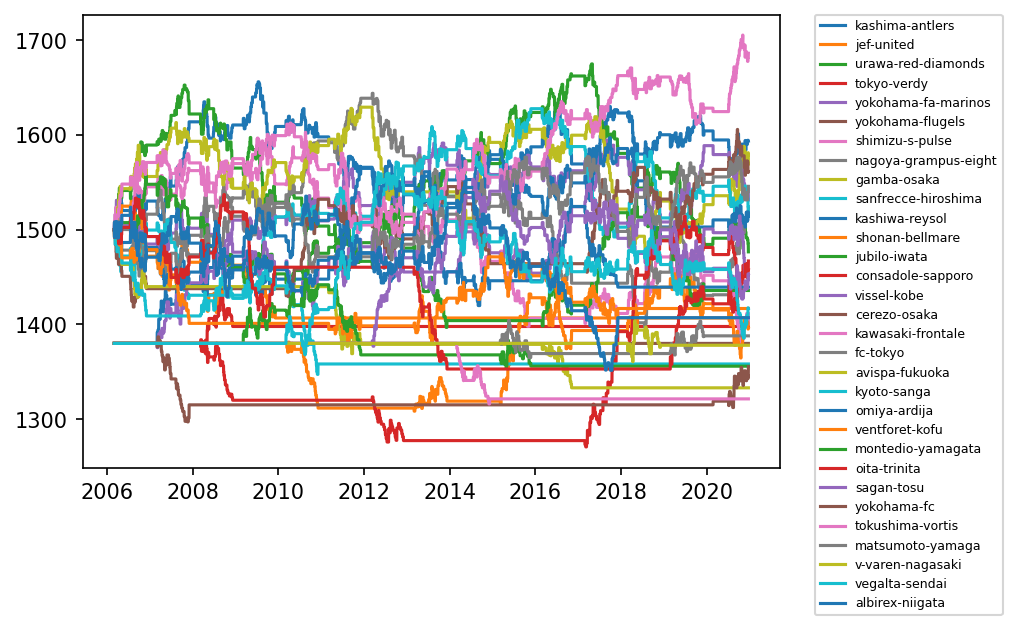

In [333]:
import matplotlib.pyplot as plt
fig = plt.figure(dpi=150)
for club in df_elo.columns:
    plt.plot(df_elo.index, df_elo[club],label=df_elo[club].name )
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=6)


In [263]:
df_elo.to_csv('./elorating.csv')